## Setup

In [37]:
%matplotlib inline

In [1]:
import pandas as pd
import json

from tests.eas.load_tracking import FreqInvarianceTest
from trace import Trace
from trappy.plotter import plot_trace
from trappy.stats.grammar import Parser
from trappy import ILinePlot

In [13]:
import logging
from conf import LisaLogging
LisaLogging.setup()
logging.getLogger('Analysis').setLevel(logging.ERROR)

2016-11-29 16:24:16,123 INFO    : root         : Using LISA logging configuration:
2016-11-29 16:24:16,124 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


## Run test workload

In [3]:
t = FreqInvarianceTest(methodName='test_task_util')

In [4]:
t.setUpClass()

2016-11-29 16:18:05,421 INFO    : LisaTest     : Setup tests execution engine...
2016-11-29 16:18:05,422 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2016-11-29 16:18:05,423 INFO    : TestEnv      : Loading default (file) target configuration
2016-11-29 16:18:05,424 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2016-11-29 16:18:05,427 INFO    : TestEnv      : Loading custom (inline) test configuration
2016-11-29 16:18:05,428 INFO    : TestEnv      : Devlib modules to load: ['bl', u'cpuidle', 'cpufreq']
2016-11-29 16:18:05,428 INFO    : TestEnv      : Connecting linux target:
2016-11-29 16:18:05,429 INFO    : TestEnv      :   username : brendan
2016-11-29 16:18:05,430 INFO    : TestEnv      :       host : 192.168.2.2
2016-11-29 16:18:05,430 INFO    : TestEnv      :   password : password
2016-11-29 16:18:05,431 INFO    : TestEnv      : Connection settings:
2016-11-29 16:18:05,432 INFO    : TestEnv      :    {

2016-11-29 16:19:11,056 INFO    : Executor     : Collected FTrace binary trace:
2016-11-29 16:19:11,058 INFO    : Executor     :    <res_dir>/rtapp:freq_450000:fie_10pct/1/trace.dat
2016-11-29 16:19:11,059 INFO    : Executor     : Collected FTrace function profiling:
2016-11-29 16:19:11,060 INFO    : Executor     :    <res_dir>/rtapp:freq_450000:fie_10pct/1/trace_stat.json
2016-11-29 16:19:11,061 INFO    : Executor     : --------------------------------------------------------------------------------
2016-11-29 16:19:11,062 INFO    : Executor     : 
2016-11-29 16:19:11,063 INFO    : Executor     : ================================================================================
2016-11-29 16:19:11,064 INFO    : Executor     : configuring target for [freq_625000] experiments
2016-11-29 16:19:12,782 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-11-29 16:19:13,688 INFO    : root         :        CPUFreq - CPU frequencies: {1: 625000}
2016-11-29 16:1

2016-11-29 16:19:38,045 INFO    : Executor     : Collected FTrace binary trace:
2016-11-29 16:19:38,047 INFO    : Executor     :    <res_dir>/rtapp:freq_625000:fie_10pct/1/trace.dat
2016-11-29 16:19:38,048 INFO    : Executor     : Collected FTrace function profiling:
2016-11-29 16:19:38,049 INFO    : Executor     :    <res_dir>/rtapp:freq_625000:fie_10pct/1/trace_stat.json
2016-11-29 16:19:38,051 INFO    : Executor     : --------------------------------------------------------------------------------
2016-11-29 16:19:38,052 INFO    : Executor     : 
2016-11-29 16:19:38,053 INFO    : Executor     : ================================================================================
2016-11-29 16:19:38,054 INFO    : Executor     : configuring target for [freq_800000] experiments
2016-11-29 16:19:39,772 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-11-29 16:19:40,677 INFO    : root         :        CPUFreq - CPU frequencies: {1: 800000}
2016-11-29 16:1

2016-11-29 16:20:03,738 INFO    : Executor     : Collected FTrace binary trace:
2016-11-29 16:20:03,740 INFO    : Executor     :    <res_dir>/rtapp:freq_800000:fie_10pct/1/trace.dat
2016-11-29 16:20:03,741 INFO    : Executor     : Collected FTrace function profiling:
2016-11-29 16:20:03,742 INFO    : Executor     :    <res_dir>/rtapp:freq_800000:fie_10pct/1/trace_stat.json
2016-11-29 16:20:03,743 INFO    : Executor     : --------------------------------------------------------------------------------
2016-11-29 16:20:03,744 INFO    : Executor     : 
2016-11-29 16:20:03,745 INFO    : Executor     : ================================================================================
2016-11-29 16:20:03,746 INFO    : Executor     : configuring target for [freq_950000] experiments
2016-11-29 16:20:05,464 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-11-29 16:20:06,369 INFO    : root         :        CPUFreq - CPU frequencies: {1: 950000}
2016-11-29 16:2

2016-11-29 16:20:29,035 INFO    : Executor     : Collected FTrace binary trace:
2016-11-29 16:20:29,037 INFO    : Executor     :    <res_dir>/rtapp:freq_950000:fie_10pct/1/trace.dat
2016-11-29 16:20:29,038 INFO    : Executor     : Collected FTrace function profiling:
2016-11-29 16:20:29,039 INFO    : Executor     :    <res_dir>/rtapp:freq_950000:fie_10pct/1/trace_stat.json
2016-11-29 16:20:29,040 INFO    : Executor     : --------------------------------------------------------------------------------
2016-11-29 16:20:29,041 INFO    : Executor     : 
2016-11-29 16:20:29,042 INFO    : Executor     : ================================================================================
2016-11-29 16:20:29,043 INFO    : Executor     : configuring target for [freq_1100000] experiments
2016-11-29 16:20:30,760 INFO    : Executor     : Configuring all CPUs to use [userspace] cpufreq governor
2016-11-29 16:20:31,666 INFO    : root         :        CPUFreq - CPU frequencies: {1: 1100000}
2016-11-29 16

2016-11-29 16:20:54,210 INFO    : Executor     : Collected FTrace binary trace:
2016-11-29 16:20:54,212 INFO    : Executor     :    <res_dir>/rtapp:freq_1100000:fie_10pct/1/trace.dat
2016-11-29 16:20:54,213 INFO    : Executor     : Collected FTrace function profiling:
2016-11-29 16:20:54,214 INFO    : Executor     :    <res_dir>/rtapp:freq_1100000:fie_10pct/1/trace_stat.json
2016-11-29 16:20:54,216 INFO    : Executor     : --------------------------------------------------------------------------------
2016-11-29 16:20:54,217 INFO    : Executor     : 
2016-11-29 16:20:54,218 INFO    : Executor     : ################################################################################
2016-11-29 16:20:54,219 INFO    : Executor     : Experiments execution completed
2016-11-29 16:20:54,220 INFO    : Executor     : ################################################################################
2016-11-29 16:20:54,221 INFO    : Executor     : Results available in:
2016-11-29 16:20:54,222 INFO  

## Show variance in util_avg and load_avg

In [46]:
# Get the frequency an experiment was run at
def experiment_freq(exp):
    [cpu] = exp.wload.cpus
    freq = exp.conf['cpufreq']['freqs'][cpu]
    return freq
freqs = [experiment_freq(e) for e in t.executor.experiments]
freqs

[450000, 625000, 800000, 950000, 1100000]

In [50]:
def plot_signal_against_freq(signal):
    means = [t.get_signal_mean(e, signal) for e in t.executor.experiments]
    limits = (min(means) * 0.99, max(means) * 1.01)
    pd.DataFrame(means, index=freqs, columns=['Mean ' + signal]).plot(kind='bar', ylim=limits)

### Plot of variation of util_avg value with frequency:

In [ ]:
plot_signal_against_freq('util_avg')

### And the same thing for load_avg:

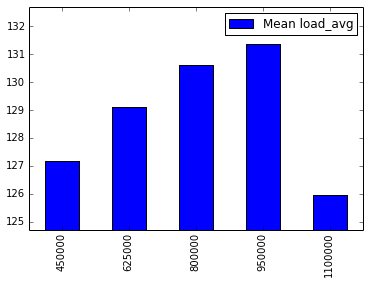

In [49]:
util_avg_means = [t.get_signal_mean(e, 'load_avg') for e in t.executor.experiments]
limits = (min(util_avg_means) * 0.99, max(util_avg_means) * 1.01)
pd.DataFrame(util_avg_means, index=freqs, columns=['Mean load_avg']).plot(kind='bar', ylim=limits)

## Examine trace from workload execution

The log `setUpClass` call above shows the experiments that were run. Use the function below to get a plot from a given experiment of the `util_avg` scheduler signal for that workload's tasks, along with the expected mean value.

In [5]:
def examine_experiment(idx, signal):
    experiment = t.executor.experiments[idx]
    
    print "Experiment configuration:" 
    print json.dumps(experiment.conf, indent=4)
    events = t.te.test_conf["ftrace"]["events"]
    
    # todo add get_trace method
    tasks = experiment.wload.tasks.keys()
    #trace = Trace(t.te.platform, experiment.out_dir, events, tasks)
    #print "Trace plot:"
    #plot_trace(trace.ftrace)
    
    # Get observed signal
    signal_df = t.get_sched_signal(experiment, signal)
#    return signal_df
    # Get expected average value for util_avg signal
    expected_util_avg_mean = t.get_expected_util_avg(experiment)
    
    # Plot util avg signal with expected mean value
    util_avg_mean = pd.Series([expected_util_avg_mean], name="expected_util_avg", index=[signal_df.index[0]])
    df = pd.concat([signal_df, util_avg_mean], axis=1).fillna(method="ffill")
    ILinePlot(df, column=[signal, "expected_util_avg"], drawstyle="steps-post").view()

In [16]:
plot_trace(t.get_trace(t.executor.experiments[0]).ftrace)

In [15]:
df = examine_experiment(-1, "util_avg")

Experiment configuration:
{
    "dtb": null, 
    "kernel": null, 
    "tag": "freq_1100000", 
    "flags": "ftrace", 
    "cpufreq": {
        "freqs": {
            "1": 1100000
        }, 
        "governor": "userspace"
    }
}


""
""


In [14]:
df = examine_experiment(-1, "load_avg")

Experiment configuration:
{
    "dtb": null, 
    "kernel": null, 
    "tag": "freq_1100000", 
    "flags": "ftrace", 
    "cpufreq": {
        "freqs": {
            "1": 1100000
        }, 
        "governor": "userspace"
    }
}


""
""
